In [10]:
import os
import sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
from pyidi import ROISelect
from matplotlib.path import Path
import pickle as pk
from pixel_setter2 import PixelSetter#, play_video, detect_peaks
from pixel_setter import play_video
from scipy.ndimage import uniform_filter
from EMA_functions import *
from Feature_selecter import *
import glob
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')
root_video = os.path.normpath('D:/thijsmas/wing')
root_mraw = os.path.normpath('D:/thijsmas/wing/mraw')
path_list = glob.glob(os.path.join(root_video, '*.cine'))

In [3]:
file_name =  '1xyz_a_rev1_wcam.cine'
EMA_structure = EMA_Structure(file_name[:-5] + '.cih')
video = EMA_structure.open_video(add_extension=False)
video.info


D:/thijsmas\wing\mraw\1xyz_a_rev1_wcam.cih


{'Record Rate(fps)': 400,
 'Shutter Speed(s)': '6e-06',
 'Total Frame': 9506,
 'Original Total Frame': 9506,
 'Start Frame': 0,
 'Image Width': 1280,
 'Image Height': 320,
 'Color Type': 'Mono',
 'Color Bit': 16,
 'File Format': 'mraw',
 'EffectiveBit Depth': 12,
 'Comment Text': 'Generated sequence. Modify measurement info in created .cih file if necessary.',
 'EffectiveBit Side': 'Lower',
 'Post trigger': 5366}

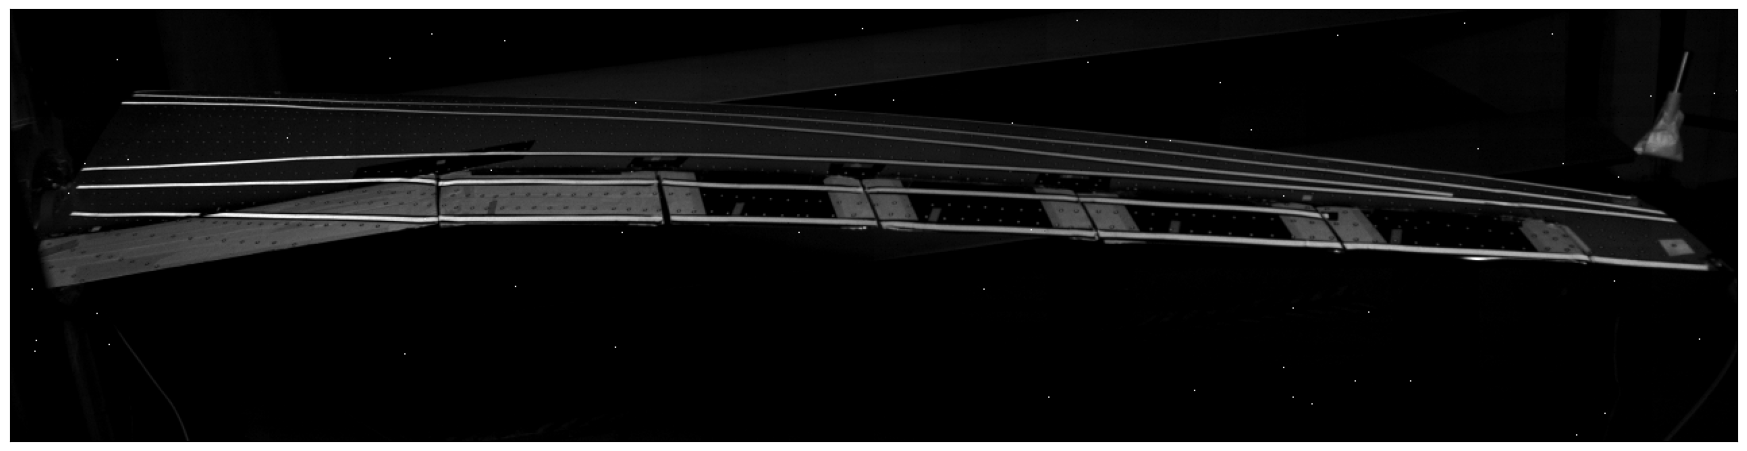

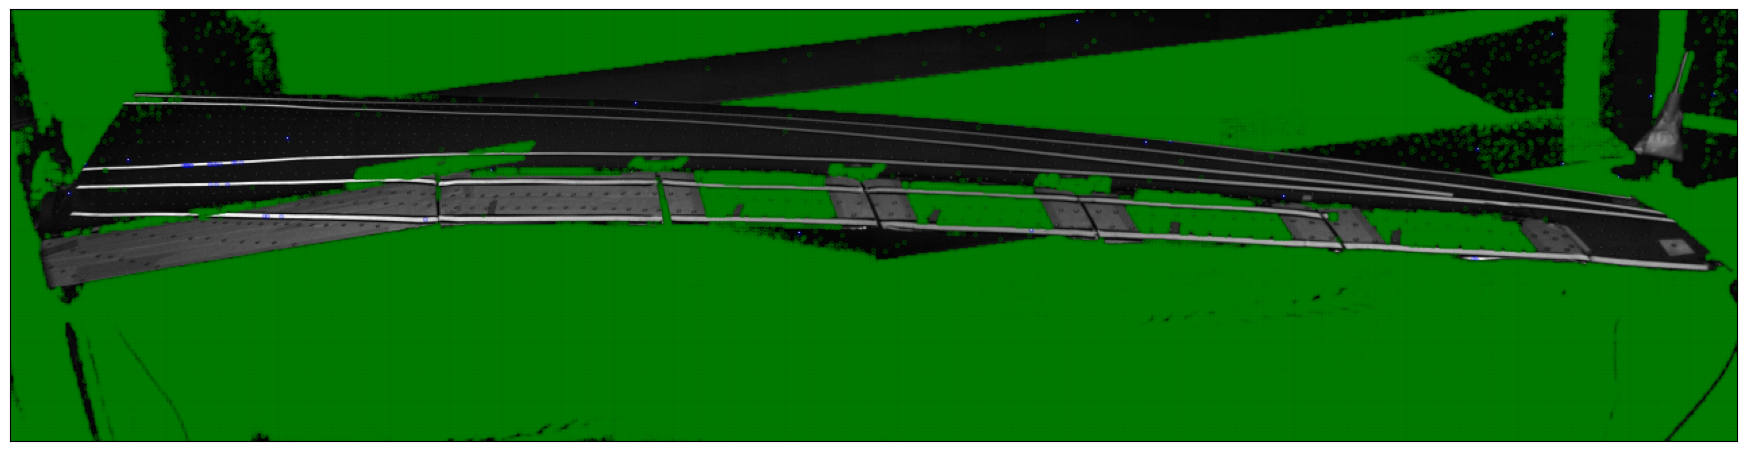

In [4]:
%matplotlib inline
sequential_image_n = 0
still_image = video.mraw[sequential_image_n]

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False, bit_depth = video.info['EffectiveBit Depth'])
# fig.savefig(os.path.join(root_drive_sim, 'still images', f'{file_name}_frame_sat0.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=True, bit_depth = video.info['EffectiveBit Depth'])
# fig.savefig(os.path.join(root_drive_sim, 'still images','with saturation', f'{file_name}_frame_sat1.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

In [17]:
roi_select = ROISelect(video)
roi_select.polygon
polygon = np.array(roi_select.polygon)

# polygon = np.array([[  47,   59,   83,  110,  121,  173,  205,  200,  193,  185,  172, 170,  170,  222,  168,   78,   47],
#        [  83,  520,  822, 1121, 1217, 1269, 1276, 1179,  987,  809,  645, 489,  319,   23,   10,   50,   83]])

polygon

array([[  47,   59,   83,  110,  121,  173,  205,  200,  193,  185,  172,
         170,  170,  222,  168,   78,   47],
       [  83,  520,  822, 1121, 1217, 1269, 1276, 1179,  987,  809,  645,
         489,  319,   23,   10,   50,   83]])

In [ ]:
%matplotlib qt
first_frame = 1
ani = play_video(video, range(first_frame,video.N - 1), interval=30)

# Set points 2D

In [99]:
%matplotlib qt
roi_size = (7,7)
reference_image = (0, 150)
n_tracking_points = 6000
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)

path = Path(polygon.T)
mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])]))
mask_image = mask_image.reshape(mean_image.shape)

feature_selecter = FeatureSelecter(mean_image)
feature_selecter.set_filter_method('eig0', roi_size)
score_full = feature_selecter.apply_filter(downsample=1)
maxima2d = feature_selecter.pick_max_filter(score_image = score_full, min_distance = roi_size, absolute_treshold = 0.0) #, top_n_points = n_tracking_points
feature_selecter.plot_score_image(maxima=True, umin=0)


video.set_method('lk')
video.method.configure(roi_size = roi_size, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
mask_points = path.contains_points(maxima2d)
video.set_points(maxima2d[mask_points])
video.show_points()

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


In [ ]:
displacement = video.get_displacements(processes = 24)
EMA_structure.displacements = displacement
EMA_structure.maxima = maxima2d[mask_points]
EMA_structure.mean_image = mean_image
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, 'EMA structure', file_name+f'_2d_roi{roi_size[0]}x{roi_size[1]}.pkl')
with open(path, 'wb') as f:
    pk.dump(EMA_structure, f)

In [ ]:
%matplotlib qt
td     = displacement +  maxima2d.reshape(len(maxima2d),1,2)
ani = play_video(video, range(1000, video.N-1), interval=30, points=td, axis=([0, video.info['Image Width']],[video.info['Image Height'], 0]))

## Set points 1D

In [102]:
%matplotlib qt
n_tracking_points = 6000
Gi, Gj = np.gradient(mean_image)
s = np.array([0,1])
Gs  = s[0]*Gj + s[1]*Gi
filtered_image = uniform_filter(Gs, size=roi_size[0])
maxima1d = feature_selecter.pick_max_filter(score_image = Gi, min_distance = roi_size[0], absolute_treshold = None, threshold_percentage = 0, top_n_points = n_tracking_points)
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
mask_points = path.contains_points(maxima1d)

ax.imshow(mean_image, cmap='gray')
ax.scatter(maxima1d[mask_points][:, 1], maxima1d[mask_points][:, 0], s=5, c='r')
plt.show()

In [ ]:
video.set_method('lk_1D')
d = (0,1)
video.method.configure(roi_size = roi_size, d = d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
video.set_points(maxima1d[mask_points])

In [ ]:
displacement_1d = video.get_displacements(processes=24)
EMA_structure.displacements = displacement
EMA_structure.maxima = maxima1d
EMA_structure.mean_image = mean_image
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, 'EMA structure', file_name+f'_1d_roi{roi_size[0]}x{roi_size[1]}.pkl')
with open(path, 'wb') as f:
    pk.dump(EMA_structure, f)

In [103]:
roi_size_2d = (7,7)
roi_size_1d = (3,3)
reference_image = (0, 150)
n_tracking_points_1d = 6000
n_tracking_points_2D = 6000
path = Path(polygon.T)
d = (0,1)
s = np.array([0,1])
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'

for path_c in path_list:
    file_name = os.path.basename(path_c)
    EMA_structure = EMA_Structure(file_name[:-5] + '.cih')
    video = EMA_structure.open_video(add_extension=False)

    mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)

    feature_selecter = FeatureSelecter(mean_image)
    feature_selecter.set_filter_method('eig0', roi_size_2d)
    score_full = feature_selecter.apply_filter(downsample=1)
    maxima2d = feature_selecter.pick_max_filter(score_image = score_full, min_distance = roi_size_2d, absolute_treshold = 0.0) #, top_n_points = n_tracking_points
    mask_points = path.contains_points(maxima2d)

    video.set_method('lk')
    video.method.configure(roi_size = roi_size_2d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
    video.set_points(maxima2d[mask_points])

    displacement = video.get_displacements(processes = 24)
    EMA_structure.displacements = displacement
    EMA_structure.maxima = maxima2d[mask_points]
    EMA_structure.mean_image = mean_image
    
    path = os.path.join(root, 'EMA structure', file_name+f'_2d_roi{roi_size_2d[0]}x{roi_size_2d[1]}.pkl')
    with open(path, 'wb') as f:
        pk.dump(EMA_structure, f)
    
    Gi, Gj = np.gradient(mean_image)
    
    Gs  = s[0]*Gj + s[1]*Gi
    filtered_image = uniform_filter(Gs, size=roi_size_1d[0])
    maxima1d = feature_selecter.pick_max_filter(score_image = Gi, min_distance = roi_size_1d[0], absolute_treshold = None, threshold_percentage = 0, top_n_points = n_tracking_points)

    mask_points = path.contains_points(maxima1d)
    video.set_method('lk_1D')
    video.method.configure(roi_size = roi_size_1d, d = d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
    video.set_points(maxima1d[mask_points])

    displacement = video.get_displacements(processes=24)
    EMA_structure.displacements = displacement
    EMA_structure.maxima = maxima1d[mask_points]
    EMA_structure.mean_image = mean_image

    path = os.path.join(root, 'EMA structure', file_name+f'_1d_roi{roi_size_1d[0]}x{roi_size_1d[1]}.pkl')
    with open(path, 'wb') as f:
        pk.dump(EMA_structure, f)


SyntaxError: invalid syntax (2006915643.py, line 41)